# Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from glob import glob
from tqdm import tqdm
import rpy2
%load_ext rpy2.ipython

In [2]:
%%R 
library(lme4); library(lmerTest)
library(brms)

Loading required package: Matrix

Attaching package: ‘lmerTest’

The following object is masked from ‘package:lme4’:

    lmer

The following object is masked from ‘package:stats’:

    step

Loading required package: Rcpp
Loading 'brms' package (version 2.21.0). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').

Attaching package: ‘brms’

The following object is masked from ‘package:lme4’:

    ngrps

The following object is masked from ‘package:stats’:

    ar



In [3]:
plt.rcParams.update({'font.size': 18})
pd.options.mode.chained_assignment = None  # default='warn'

In [4]:
def get_bayesian_p(draws,threshold=0):
    """
    Compute Bayesian P-value from posterior
    """
    mu = draws.mean()
    p  = (draws<threshold).mean()
    if mu > 0: return p
    return 1-p

def get_bf(post, rope=(-.01,.01), bf_type="10"):
    """
    Compute Bayes' Factor using Savage-Dickey ratio and flat priors (default for brms `b` coefs.)
    Uses a ROPE of (-.01,.01) by default
    """
    mod_p   = post.between(*rope).mean()
    prior_p = 1/(rope[1]-rope[0]) # https://en.wikipedia.org/wiki/Continuous_uniform_distribution
    if np.isinf(prior_p): return np.inf
    bf = mod_p/prior_p
    if bf_type=="01": return bf
    return 1/bf
    

def plot_trace(post,nchain=4,ndraw=3000,keep="b_"):
    """
    Plot traceplot and density plots for Bayesian posterior
    """
    post = post.iloc[:,post.columns.str.contains(keep)]
    post["chain"] = np.repeat(np.arange(nchain),ndraw)
    post["draws"] = np.tile(np.arange(ndraw),nchain)

    fig, axes = plt.subplots(post.shape[1]-2,2, figsize=(10,10), constrained_layout=True)

    for i in range(post.shape[1]-2):
        ## Density plot
        sns.kdeplot(data=post, x=post.columns[i], hue="chain", ax=axes[i,0])
        axes[i,0].set(xlabel="",title=post.columns[i])
        axes[i,0].legend([],[],frameon=False)

        ## Traceplot
        sns.lineplot(data=post, x="draws", y=post.columns[i], hue="chain", ax=axes[i,1],
                    errorbar=None)
        axes[i,1].set(xlabel="Sample",ylabel="",title=post.columns[i])
        axes[i,1].legend([],[],frameon=False)
    
    return fig, axes

def bmlm_summary(post, keep="b_"): 
    """
    Create output table with posterior mean, 95% CI, and Bayesian P-value
    """
    post = post.iloc[:,post.columns.str.contains("b_")]
    summary = (post.describe(percentiles=(0.025,0.975)).T)[["mean","2.5%","97.5%"]]
    summary["P"]  = [get_bayesian_p(post.iloc[:,i]) for i in range(post.shape[1])] 
    summary["BF"] = [get_bf(post.iloc[:,i]) for i in range(post.shape[1])] 
    return summary

In [5]:
import session_info
session_info.show()

In [6]:
%%R

sessionInfo()

R version 4.4.0 (2024-04-24)
Platform: x86_64-apple-darwin20
Running under: macOS Big Sur ... 10.16

Matrix products: default
BLAS:   /System/Library/Frameworks/Accelerate.framework/Versions/A/Frameworks/vecLib.framework/Versions/A/libBLAS.dylib 
LAPACK: /Library/Frameworks/R.framework/Versions/4.4-x86_64/Resources/lib/libRlapack.dylib;  LAPACK version 3.12.0

locale:
[1] en_CA.UTF-8/en_CA.UTF-8/en_CA.UTF-8/C/en_CA.UTF-8/en_CA.UTF-8

time zone: America/Toronto
tzcode source: internal

attached base packages:
[1] tools     stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
[1] brms_2.21.0    Rcpp_1.0.12    lmerTest_3.1-3 lme4_1.1-35.3  Matrix_1.7-0  

loaded via a namespace (and not attached):
 [1] bridgesampling_1.1-2 tensorA_0.36.2.1     utf8_1.2.4          
 [4] generics_0.1.3       stringi_1.8.4        lattice_0.22-6      
 [7] magrittr_2.0.3       grid_4.4.0           mvtnorm_1.2-4       
[10] jsonlite_1.8.8       pkgbuild_1.4.4     

# Load data

- `data/` contains raw output of behavioural data
- `eye/processed` contains pupillometry processed + behavioural data files. See [process.py](eye/process.py)

In [7]:
files = glob("eye/processed/*.csv") #glob("data/**/Data/*.csv",recursive=True)
files = [f for f in files if "survey" not in f]

print(f"Number of raw files: {len(files)}")

Number of raw files: 81


In [8]:
dat = pd.concat([pd.read_csv(f) for f in files])
print(dat.columns)
dat.head()

Index(['Unnamed: 0', 'Phase', 'Block', 'TrialType', 'ifProgress', 'Trial',
       'PFilled', 'TimeOut', 'RT', 'Choice', 'CorrectAnswer', 'CorrectLoc',
       'Feedback', 'CorrectCount', 'CorrectRequire', 'PFilledNew', 'START',
       'KeyPressTime', 'FeedbackTime', 'END', 'ifLookedFix', 'ifLookProg',
       'progLookDur', 'progStartLoc', 'progEndLoc', 'progPosition', 'ITI1',
       'progLookStart', 'progLookEnd', 'ITI2', 'PID', 'SONA', 'Age', 'Gender',
       'TIME', 'EXPERIMENTER', 'Unnamed: 35', 'phasic_pupil_base',
       'phasic_pupil_terp_mean', 'phasic_pupil_terp_max', 'tonic_pupil_base',
       'tonic_pupil_terp_mean', 'tonic_pupil_terp_max'],
      dtype='object')


,Unnamed: 0,Phase,Block,TrialType,ifProgress,Trial,PFilled,TimeOut,RT,Choice,...,Gender,TIME,EXPERIMENTER,Unnamed: 35,phasic_pupil_base,phasic_pupil_terp_mean,phasic_pupil_terp_max,tonic_pupil_base,tonic_pupil_terp_mean,tonic_pupil_terp_max
0,0,PraticeBall,None,Ball,None,1,0.0,0.75,NaN,NaN,...,F,230313_124512,AB,NaN,0.512599,0.445316,0.567576,-0.514849,-0.567734,-0.514849
1,1,PraticeBall,None,Fixation,None,2,NaN,NaN,NaN,NaN,...,F,230313_124512,AB,NaN,NaN,0.678315,0.765764,NaN,-0.790933,-0.716135
2,2,PraticeBall,None,Ball,None,3,0.0,0.75,NaN,NaN,...,F,230313_124512,AB,NaN,0.791242,0.803727,0.898794,-0.907831,-0.989769,-0.930095
3,3,PraticeBall,None,Fixation,None,4,NaN,NaN,NaN,NaN,...,F,230313_124512,AB,NaN,NaN,0.797120,0.820620,NaN,-1.316647,-1.231532
4,4,PraticeBall,None,Ball,None,5,0.0,0.75,0.602777,3.0,...,F,230313_124512,AB,NaN,0.783553,0.631506,0.786394,-1.449245,-1.528918,-1.474420


# Clean data

## Overwrite `PID` with `SONA` variable, because `PID` contains multiple assignments per subject

In [9]:
dat["PID"] = dat["SONA"].copy()

## Check to see if subjects have correct number of trials

<AxesSubplot:xlabel='PID', ylabel='Count'>

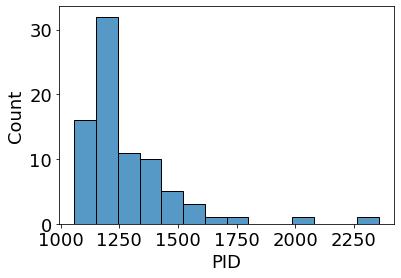

In [10]:
sns.histplot(dat.PID.value_counts())

## Keep only `Task` phase

In [11]:
dat = dat[dat.Phase=="Task"]

## Code accuracy from feedback

In [12]:
dat["Accuracy"] = (dat.Feedback=="CORRECT").astype(int)

## Add intelligible condition labels

In [13]:
dat["ProgressLab"] = np.where(dat.ifProgress=='0', "No Progress", "Progress")
dat["ProgressLab"] = pd.Categorical(dat["ProgressLab"], ordered=True)

## Split behavioural trials and fixation trials

In [14]:
behav, eye = dat[dat.TrialType=="Ball"], dat[dat.TrialType=="Fixation"]

## Append behavioural data to fixation data and vice-versa

In [15]:
eye["PFilled"]  = behav["PFilledNew"].values
eye["Accuracy"] = behav["Accuracy"].values
eye["Feedback"] = behav["Feedback"].values

In [16]:
behav["ifLookProg"] = eye["ifLookProg"].values

## Remove timeouts in both dataframes

In [17]:
ptimeout = (behav.Feedback=="SLOW").mean()
print(f"P(Timeouts) = {ptimeout:.2f}")

P(Timeouts) = 0.08


In [18]:
behav = behav[behav.Feedback != "SLOW"]
eye   = eye[eye.Feedback != "SLOW"]

## Print descriptive information

In [19]:
print(f"Number of subjects                 = {dat.SONA.unique().shape[0]}")
print(f"Average age                        = {behav.Age.mean():.2f} (SD = {behav.Age.std():.2f})")
print(f"Number of behavioural observations = {behav.shape[0]}")
print(f"Number of fixation observations    = {eye.shape[0]}")
print("Median block length                = "+ str(behav[["PID","Block"]].value_counts().median()))
print(f"Min num. correct needed            = {behav.CorrectRequire.min()}")
print(f"Max num. correct needed            = {behav.CorrectRequire.max()}")
print("Gender split:")
behav.drop_duplicates("PID").Gender.value_counts()

Number of subjects                 = 81
Average age                        = 21.60 (SD = 6.09)
Number of behavioural observations = 41674
Number of fixation observations    = 41674
Median block length                = 32.0
Min num. correct needed            = 25.0
Max num. correct needed            = 35.0
Gender split:


F    60
M    20
O     1
Name: Gender, dtype: int64

# Analyze performance data

RT and accuracy rates were predicted using generalized linear multilevel modeling techniques, as implemented in the R package `lme4` (frequentist) and `brms` (Bayesian). Specifically, both linear and quadratic terms are included to test for both linear and non-linear trends in behaviour. On the basis of past work ([1](https://psyarxiv.com/gxnk9/), [2](https://psycnet.apa.org/record/2022-58573-001)), we would anticipate a quadratic effect in both variables, which would be moderated by progress condition.

The specific model formulation is as follows: 

$$ y_{ij} = \gamma_0 + U_{0j} + \gamma_1\text{Condition}_{ij} + (\gamma_2+U_{2j})\text{P(Filled)}_{ij} + \gamma_3\text{P(Filled)}^2_{ij} +  \gamma_4\text{Block}_{ij}  + \gamma_5\left(\text{Condition} \times \text{P(Filled)}_{ij}\right) + \gamma_6\left(\text{Condition} \times \text{P(Filled)}^2_{ij}\right) + \epsilon$$

$$ U \sim MVN(0, \Sigma) $$

$$ \Sigma  = 
\begin{bmatrix}
\tau_0 & \rho_{02} \\ 
\rho_{02} & \tau_2 \\
\end{bmatrix} 
$$

$$ \epsilon \sim N(0, \sigma) $$

where $y_{ij}$ is the outcome variable, either log response times or accuracy (1=correct, 0=incorrect) for each participant $j$ on trial $i$. In the case of accuracy, the log-odds are predicted, $y_{ij} = \log{\frac{P(Accuracy=1)}{1-P(Accuracy=1)}}$. $\gamma$ refers to fixed effects and $\tau$ to random variance. Unless otherwise stated, all random variances are fixed to 0. $\rho$ refers to random effects correlations and $\sigma$ to residual noise, which is fixed in the accuracy model (for more information, see [4](https://psyarxiv.com/v68wb/)). Finally, text strings refer to observed variables. Specifically:

- $Condition$. Progress condition: -0.5 = No Progress, 0.5 = Progress
- $P(Filled)$. Proportion of the progress bar that is filled -- i.e., proximity to the goal. Raw values range from 0 (empty) to 1 (full). Here, scores are centred at 0.5. 
- $P(Filled)^2$. Same as $P(Filled)$ but squared.
- $Block$. Task block (1-16). Centred at median.



## Average accuracy histogram and conditional accuracy plot

/var/folders/2z/_glny5015ksc1wjgxn06k96m0000gn/T/ipykernel_42720/33580643.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set(xlabel="RT (s.)", ylabel="P(Correct)", ylim=[.75,1],


[Text(0.5, 0, 'RT (s.)'),
 Text(0, 0.5, 'P(Correct)'),
 (0.75, 1.0),
 [Text(-5.0, 0, '0.44'),
  Text(0.0, 0, '0.47'),
  Text(5.0, 0, '0.49'),
  Text(10.0, 0, '0.51'),
  Text(15.0, 0, '0.52')]]

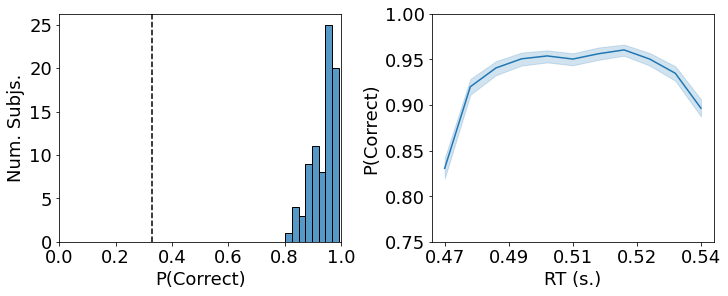

In [20]:
fig, ax = plt.subplots(1,2, figsize=(10,4), constrained_layout=True)

## historgram
mu = behav.groupby("PID")["Accuracy"].mean()
sns.histplot(x=mu, ax=ax[0])
ax[0].set(xlabel="P(Correct)", ylabel="Num. Subjs.", xlim=[0,1])
ax[0].axvline(0.33, ls="--", color="black", label="Chance")

## conditional accuracy
behav["RT_bin"] = pd.qcut(behav.RT,11, labels=False)
sns.lineplot(data=behav, x="RT_bin", y="Accuracy", ax=ax[1])
ax[1].set(xlabel="RT (s.)", ylabel="P(Correct)", ylim=[.75,1],
          xticklabels=behav.groupby("RT_bin")["RT"].median().unique().round(2))


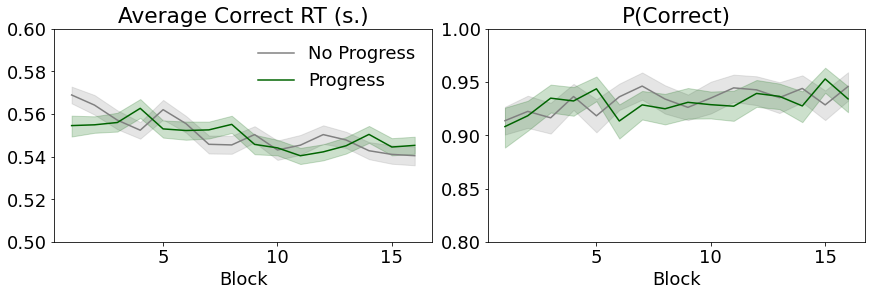

In [21]:
nbin = 6
behav["proxbin"] = pd.qcut(behav.PFilled, nbin, labels=False)
proxlabs = np.linspace(0,1,num=nbin).round(2)
behav["Block"] = behav["Block"].astype(int)

cor = behav[behav.Accuracy==1]


fig, ax = plt.subplots(1,2, figsize=(12,4), constrained_layout=True)

sns.lineplot(data=cor, x="Block", y="RT", hue="ProgressLab", ax = ax[0], 
             palette=("grey","darkgreen"))
ax[0].set(xlabel="Block", ylabel="", title="Average Correct RT (s.)", ylim=[.5,.6])
ax[0].legend(frameon=False)

sns.lineplot(data=behav, x="Block", y="Accuracy", hue="ProgressLab", ax = ax[1], 
             palette=("grey","darkgreen"))
ax[1].set(xlabel="Block", ylabel="", title="P(Correct)", ylim=(.8,1))
ax[1].legend([],[],frameon=False)


## RT proximity effects

### Isolate correct responses

In [22]:
cor = behav[behav.Accuracy==1]

### Visualize

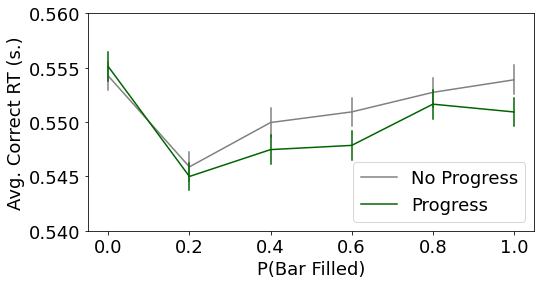

In [23]:
fig, ax = plt.subplots(1, figsize=(8,4))

nbin = 6
cor["proxbin"] = pd.qcut(cor.PFilled, nbin, labels=False)
proxlabs = np.linspace(0,1,num=nbin).round(2)

sns.lineplot(data=cor, x="proxbin", y="RT", hue="ProgressLab", ax=ax, 
            errorbar="se", err_style="bars",
             palette=("grey","darkgreen"))
ax.set(xlabel="P(Bar Filled)", 
       ylabel="Avg. Correct RT (s.)", 
       ylim=[.54,.56],
      xticks=range(nbin), xticklabels=proxlabs)
ax.legend(title="")

#### Visualize with moving average

In [24]:
cor = behav[behav.Accuracy==1]
cor["TrialCor"]  = cor.groupby(["PID","ProgressLab","Block"]).cumcount()+1
cor["RollingRT"] = cor.RT.rolling(10).mean()

cor = cor[cor.TrialCor<=25] ## remove anything unequal
cor = cor.reset_index(drop=True)

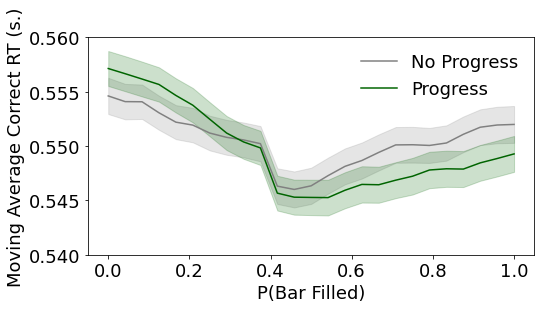

In [25]:
fig, ax = plt.subplots(1, figsize=(8,4))

nticks = cor.TrialCor.unique().shape[0]
sns.lineplot(data=cor, x="TrialCor", y="RollingRT", hue="ProgressLab", ax=ax, 
            errorbar="se",
             palette=("grey","darkgreen"))
ax.set(xlabel="P(Bar Filled)", 
       ylabel="Moving Average Correct RT (s.)", 
       ylim=[.54,.56],
      xticks=np.linspace(1,nticks,num=6), xticklabels=np.round(np.linspace(0,1,num=6),2))
ax.legend(title="", frameon=False)

### Model

In [26]:
behav["ifProgress_c"] = behav.ifProgress.astype(float) - 0.5
behav["PFilled2"]     = behav.PFilled**2
behav["PFilled_c"]    = behav.PFilled-.5
behav["PFilled2_c"]   = behav.PFilled2-np.median(behav.PFilled2.unique())
behav["Accuracy_c"]   = behav.Accuracy - .5
behav["Block_c"]      = behav.Block.astype(float) - behav.Block.astype(float).median()
behav["log_rt"]       = np.log(behav.RT)

#### Frequentist

Attempted models which failed to converge or hit singularity: 

- ...`(PFilled_c + PFillled2_c|PID)`. $\tau^2_{PFilled2} \approx 0$


In [27]:
%%R -i behav -o rt_mod_f

# rt_mod_f = lmer(log_rt ~ ifProgress_c * (PFilled_c + PFilled2_c) +
#                  Block_c + (PFilled_c|PID),
#                 data=behav)
# saveRDS(rt_mod_f, "out/rt_lmer_f.rds")

rt_mod_f = readRDS("out/rt_lmer_f.rds")
summary(rt_mod_f)

/opt/anaconda3/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '
/opt/anaconda3/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "progStartLoc". Fall back to string conversion. The error is: <class 'float'>
  warnings.warn('Error while trying to convert '
/opt/anaconda3/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "progEndLoc". Fall back to string conversion. The error is: <class 'float'>
  warnings.warn('Error while trying to convert '
/opt/anaconda3/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "progPosition". Fall back to string conversion. The error is: <class 'float'>
  war

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: log_rt ~ ifProgress_c * (PFilled_c + PFilled2_c) + Block_c +  
    (PFilled_c | PID)
   Data: behav

REML criterion at convergence: -53095.3

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-28.1915  -0.6718  -0.0478   0.6279   3.8324 

Random effects:
 Groups   Name        Variance  Std.Dev. Corr
 PID      (Intercept) 0.0033913 0.05823      
          PFilled_c   0.0002689 0.01640  0.42
 Residual             0.0161889 0.12724      
Number of obs: 41674, groups:  PID, 81

Fixed effects:
                          Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)             -6.158e-01  6.544e-03  8.219e+01 -94.099   <2e-16 ***
ifProgress_c            -3.113e-03  1.959e-03  4.151e+04  -1.589   0.1121    
PFilled_c               -8.177e-02  8.594e-03  5.956e+03  -9.515   <2e-16 ***
PFilled2_c               8.578e-02  8.398e-03  4.152e+04  10.214   <2e-16 ***
Block_

#### Bayesian

In [28]:
%%R -i behav -o rt_mod_post

# options(mc.cores=4) # parallel processing

# rt_mod_b = brm(log_rt ~ ifProgress_c * (PFilled_c + PFilled2_c) +
#                  Block_c + (PFilled_c|PID), family=gaussian(),
#                 data=behav,
#                 iter=5000,
#                 chains=4,
#                 warmup=2000, 
#                 thin=1)

# saveRDS(rt_mod_b, "out/rt_lmer_b.rds")
# print(summary(rt_mod_b))


rt_mod_b = readRDS("out/rt_lmer_b.rds")
print(summary(rt_mod_b))
rt_mod_post = as.data.frame(rt_mod_b)

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: log_rt ~ ifProgress_c * (PFilled_c + PFilled2_c) + Block_c + (PFilled_c | PID) 
   Data: behav (Number of observations: 41674) 
  Draws: 4 chains, each with iter = 5000; warmup = 2000; thin = 1;
         total post-warmup draws = 12000

Multilevel Hyperparameters:
~PID (Number of levels: 81) 
                         Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS
sd(Intercept)                0.06      0.00     0.05     0.07 1.00      818
sd(PFilled_c)                0.02      0.00     0.01     0.02 1.00     4291
cor(Intercept,PFilled_c)     0.41      0.16     0.08     0.72 1.00     6617
                         Tail_ESS
sd(Intercept)                1649
sd(PFilled_c)                4633
cor(Intercept,PFilled_c)     5700

Regression Coefficients:
                        Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS
Intercept                  -0.62      0.01    -0.63    -0.60 1.01      309
ifProgress_c        

##### Visualize posterior draws and print Bayesian P-values

Text(0.5, 0.98, 'log(Response Times)')

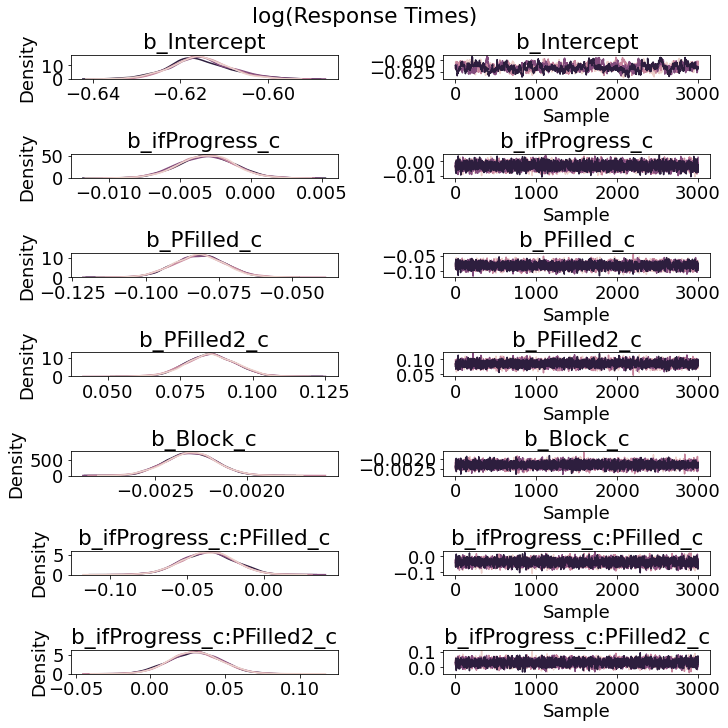

In [29]:
fig, axes = plot_trace(rt_mod_post)
fig.suptitle("log(Response Times)")

In [30]:
bmlm_summary(rt_mod_post).round(2)

/var/folders/2z/_glny5015ksc1wjgxn06k96m0000gn/T/ipykernel_42720/401475712.py:20: RuntimeWarning: divide by zero encountered in double_scalars
  return 1/bf


,mean,2.5%,97.5%,P,BF
b_Intercept,-0.62,-0.63,-0.60,0.00,inf
b_ifProgress_c,-0.00,-0.01,0.00,0.05,50.01
b_PFilled_c,-0.08,-0.10,-0.06,0.00,inf
b_PFilled2_c,0.09,0.07,0.10,0.00,inf
b_Block_c,-0.00,-0.00,-0.00,0.00,50.00
b_ifProgress_c:PFilled_c,-0.04,-0.07,-0.00,0.02,874.64
b_ifProgress_c:PFilled2_c,0.03,-0.00,0.06,0.04,464.04


## Accuracy performance effects

### Visualize

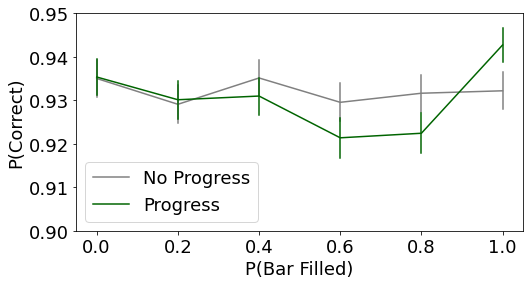

In [31]:
fig, ax = plt.subplots(1, figsize=(8,4))

nbin = 6
behav["proxbin"] = pd.qcut(behav.PFilled, nbin, labels=False)
proxlabs = np.linspace(0,1,num=nbin).round(2)

sns.lineplot(data=behav, x="proxbin", y="Accuracy", hue="ProgressLab", ax=ax, 
            errorbar="se",err_style="bars", palette=("grey","darkgreen"))
ax.set(xlabel="P(Bar Filled)", 
       ylabel="P(Correct)", 
       ylim=[0.9,0.95],
      xticks=range(nbin), xticklabels=proxlabs)
ax.legend(title="",loc="lower left")

### Model

In [32]:
behav["ifProgress_c"] = behav.ifProgress.astype(float) - 0.5
behav["PFilled2"]     = behav.PFilled**2
behav["PFilled_c"]    = behav.PFilled-.5
behav["PFilled2_c"]   = behav.PFilled2-np.median(behav.PFilled.unique())
behav["Accuracy_c"]   = behav.Accuracy - .5
behav["Block_c"]      = behav.Block.astype(float) - behav.Block.astype(float).median()
behav["log_rt"]       = np.log(behav.RT)

#### Frequentist

Attempted models which failed to converge or hit singularity: 

- ...`(PFilled_c + PFillled2_c|PID)`. $\tau^2_{PFilled2} \approx 0$


In [33]:
%%R -i behav -o acc_mod_f

# acc_mod_f = glmer(Accuracy ~ ifProgress_c * (PFilled_c + PFilled2_c) +
#                  Block_c + (PFilled_c|PID), family="binomial",
#                 data=behav, nAGQ=0)
# saveRDS(acc_mod_f, "out/acc_glmer_f.rds")

acc_mod_f = readRDS("out/acc_glmer_f.rds")
summary(acc_mod_f)

/opt/anaconda3/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '
/opt/anaconda3/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "progStartLoc". Fall back to string conversion. The error is: <class 'float'>
  warnings.warn('Error while trying to convert '
/opt/anaconda3/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "progEndLoc". Fall back to string conversion. The error is: <class 'float'>
  warnings.warn('Error while trying to convert '
/opt/anaconda3/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "progPosition". Fall back to string conversion. The error is: <class 'float'>
  war

Generalized linear mixed model fit by maximum likelihood (Adaptive
  Gauss-Hermite Quadrature, nAGQ = 0) [glmerMod]
 Family: binomial  ( logit )
Formula: Accuracy ~ ifProgress_c * (PFilled_c + PFilled2_c) + Block_c +  
    (PFilled_c | PID)
   Data: behav

     AIC      BIC   logLik deviance df.resid 
 19874.2  19960.6  -9927.1  19854.2    41664 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-8.8755  0.1753  0.2272  0.3186  0.5583 

Random effects:
 Groups Name        Variance Std.Dev. Corr 
 PID    (Intercept) 0.50949  0.7138        
        PFilled_c   0.04424  0.2103   -0.09
Number of obs: 41674, groups:  PID, 81

Fixed effects:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)              2.924313   0.093585  31.248  < 2e-16 ***
ifProgress_c             0.136925   0.095949   1.427   0.1536    
PFilled_c               -0.601000   0.269759  -2.228   0.0259 *  
PFilled2_c               0.613020   0.268402   2.284   0.0224 *  
Block_c        

#### Bayesian

In [34]:
%%R -i behav -o acc_mod_post

# options(mc.cores=4) # parallel processing

# acc_mod_b = brm(Accuracy ~ ifProgress_c * (PFilled_c + PFilled2_c) +
#                  Block_c + (PFilled_c + PFilled2_c||PID), family=bernoulli,
#                 data=behav,
#                 iter=5000,
#                 chains=4,
#                 warmup=2000, 
#                 thin=1)

# saveRDS(acc_mod_b, "out/acc_glmer_b.rds")
# print(summary(acc_mod_b))


acc_mod_b = readRDS("out/acc_glmer_b.rds")
print(summary(acc_mod_b))
acc_mod_post = as.data.frame(acc_mod_b)


 Family: bernoulli 
  Links: mu = logit 
Formula: Accuracy ~ ifProgress_c * (PFilled_c + PFilled2_c) + Block_c + (PFilled_c + PFilled2_c || PID) 
   Data: behav (Number of observations: 41674) 
  Draws: 4 chains, each with iter = 5000; warmup = 2000; thin = 1;
         total post-warmup draws = 12000

Multilevel Hyperparameters:
~PID (Number of levels: 81) 
               Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)      0.73      0.07     0.61     0.87 1.00     2219     4328
sd(PFilled_c)      0.18      0.11     0.01     0.41 1.00     3389     5088
sd(PFilled2_c)     0.15      0.11     0.01     0.39 1.00     2911     4739

Regression Coefficients:
                        Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS
Intercept                   2.95      0.10     2.76     3.14 1.00     1531
ifProgress_c                0.14      0.10    -0.05     0.33 1.00     7708
PFilled_c                  -0.62      0.27    -1.16    -0.09 1.00    11245
PFilled2_c    

##### Visualize posterior draws and print Bayesian P-values

Text(0.5, 0.98, 'P(Correct)')

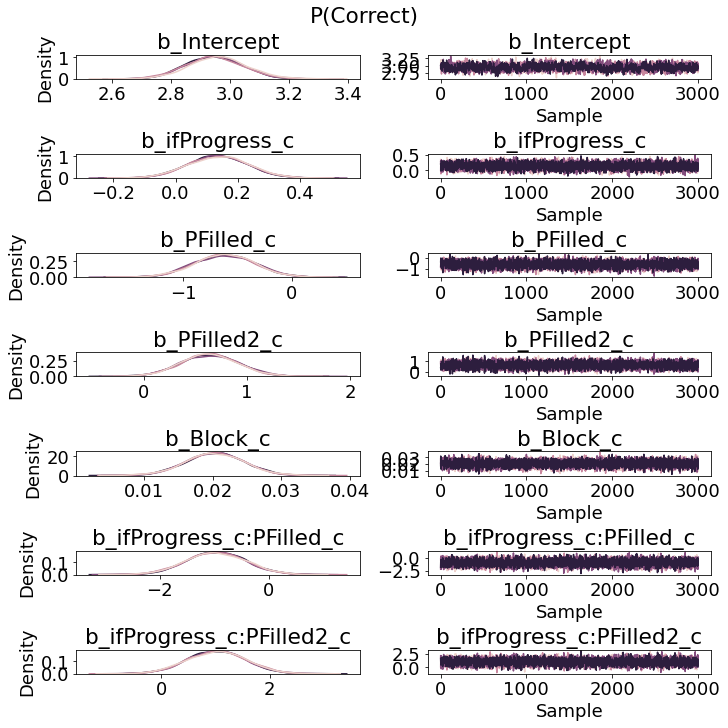

In [35]:
fig, axes = plot_trace(acc_mod_post)
fig.suptitle("P(Correct)")

In [36]:
bmlm_summary(acc_mod_post).round(2)

/var/folders/2z/_glny5015ksc1wjgxn06k96m0000gn/T/ipykernel_42720/401475712.py:20: RuntimeWarning: divide by zero encountered in double_scalars
  return 1/bf


,mean,2.5%,97.5%,P,BF
b_Intercept,2.95,2.76,3.14,0.00,inf
b_ifProgress_c,0.14,-0.05,0.33,0.08,1643.84
b_PFilled_c,-0.62,-1.16,-0.09,0.01,22222.22
b_PFilled2_c,0.64,0.11,1.18,0.01,27272.73
b_Block_c,0.02,0.01,0.03,0.00,5882.35
b_ifProgress_c:PFilled_c,-0.96,-2.01,0.11,0.04,20689.66
b_ifProgress_c:PFilled2_c,1.02,-0.04,2.08,0.03,20689.66


## Performance effects with Efficiency Score

An efficient way to visualize both RT and accuracy effects is the *Efficiency Score* (ES). 

ES refers to the proportion of correct responses per second.(See [here](https://programminginpsychology.wordpress.com/2016/02/26/inverse-efficiency-score/) for ES's counterpart: IES).

$ES_b = \frac{P(Correct)_b}{\frac{1}{N}\sum RT_b}$

where $b$ refers to a "bin" of observations.

We will set $b$ (`nbin` below) to 6 for the current analysis. 

In [37]:
def ES(rt,acc):
    return acc.mean()/rt.mean()

In [38]:
nbin = 6
behav["ProxBin"] = pd.qcut(behav.PFilled, nbin, labels=False)

### Compute trial-wise IES 


In [39]:
es = behav.groupby(["PID","ProgressLab","Block","ProxBin"],as_index=False)\
.apply(lambda x: ES(x.RT, x.Accuracy))
es.columns = ["PID", "ProgressLab", "Block", "ProxBin", "ES"]

behav = behav.merge(es)

behav.head()

,Unnamed: 0,Phase,Block,TrialType,ifProgress,Trial,PFilled,TimeOut,RT,Choice,...,proxbin,ifProgress_c,PFilled2,PFilled_c,PFilled2_c,Accuracy_c,Block_c,log_rt,ProxBin,ES
0,164,Task,1,Ball,0,7,0.000000,0.75,0.493326,3.0,...,0,-0.5,0.000000,-0.500000,-0.492857,0.5,-7.0,-0.706585,0,1.514928
1,166,Task,1,Ball,0,9,0.032258,0.75,0.471427,3.0,...,0,-0.5,0.001041,-0.467742,-0.491817,-0.5,-7.0,-0.751991,0,1.514928
2,168,Task,1,Ball,0,11,0.032258,0.75,0.574798,3.0,...,0,-0.5,0.001041,-0.467742,-0.491817,0.5,-7.0,-0.553737,0,1.514928
3,170,Task,1,Ball,0,13,0.064516,0.75,0.449883,3.0,...,0,-0.5,0.004162,-0.435484,-0.488695,0.5,-7.0,-0.798769,0,1.514928
4,172,Task,1,Ball,0,15,0.096774,0.75,0.699394,2.0,...,0,-0.5,0.009365,-0.403226,-0.483492,0.5,-7.0,-0.357542,0,1.514928


### Visualize

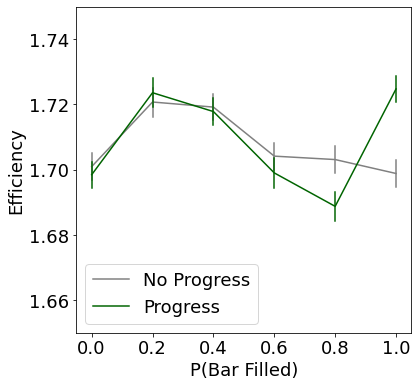

In [40]:
fig, ax = plt.subplots(1, figsize=(6,6))

sns.lineplot(data=behav, x="ProxBin", y="ES", hue="ProgressLab", ax=ax, 
            errorbar="se",err_style="bars", palette=("grey","darkgreen"))
ax.set(xlabel="P(Bar Filled)", 
       ylabel="Efficiency", 
       ylim=[1.65,1.75],
      xticks=range(nbin), xticklabels=proxlabs)
ax.legend(title="",loc="lower left")

### Model

In [41]:
behav["ifProgress_c"] = behav.ifProgress.astype(float) - 0.5
behav["PFilled2"]     = behav.PFilled**2
behav["PFilled_c"]    = behav.PFilled-.5
behav["PFilled2_c"]   = behav.PFilled2-np.median(behav.PFilled.unique())
behav["Accuracy_c"]   = behav.Accuracy - .5
behav["Block_c"]      = behav.Block.astype(float) - behav.Block.astype(float).median()

#### Frequentist

Attempted models which failed to converge or hit singularity: 

- ...`(PFilled_c + PFillled2_c|PID)`. $\tau^2_{PFilled2} \approx 0$


In [42]:
%%R -i behav -o es_mod_f

# es_mod_f = lmer(ES ~ ifProgress_c * (PFilled_c + PFilled2_c) +
#                  Block_c + (PFilled_c|PID), data=behav)
# saveRDS(es_mod_f, "out/es_lmer_f.rds")

es_mod_f = readRDS("out/es_lmer_f.rds")
summary(es_mod_f)

/opt/anaconda3/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "progStartLoc". Fall back to string conversion. The error is: <class 'float'>
  warnings.warn('Error while trying to convert '
/opt/anaconda3/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "progEndLoc". Fall back to string conversion. The error is: <class 'float'>
  warnings.warn('Error while trying to convert '
/opt/anaconda3/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "progPosition". Fall back to string conversion. The error is: <class 'float'>
  warnings.warn('Error while trying to convert '


Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: ES ~ ifProgress_c * (PFilled_c + PFilled2_c) + Block_c + (PFilled_c |  
    PID)
   Data: behav

REML criterion at convergence: -14026.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.1136 -0.6103  0.1095  0.6802  3.9933 

Random effects:
 Groups   Name        Variance Std.Dev. Corr
 PID      (Intercept) 0.019774 0.14062      
          PFilled_c   0.005593 0.07479  0.19
 Residual             0.041167 0.20290      
Number of obs: 41674, groups:  PID, 81

Fixed effects:
                          Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)              1.706e+00  1.580e-02  8.305e+01 107.945  < 2e-16 ***
ifProgress_c             1.201e-02  4.731e-03  4.151e+04   2.539  0.01112 *  
PFilled_c                2.472e-02  1.576e-02  7.562e+02   1.568  0.11730    
PFilled2_c              -2.997e-02  1.339e-02  4.151e+04  -2.238  0.02523 *  
Block_c                 

#### Bayesian

In [43]:
%%R -i behav -o es_mod_post

# options(mc.cores=4) # parallel processing

# es_mod_b = brm(ES ~ ifProgress_c * (PFilled_c + PFilled2_c) +
#                  Block_c + (PFilled_c + PFilled2_c||PID), family=gaussian,
#                 data=behav,
#                 iter=5000,
#                 chains=4,
#                 warmup=2000, 
#                 thin=1)

# saveRDS(es_mod_b, "out/es_lmer_b.rds")
# print(summary(es_mod_b))

es_mod_b = readRDS("out/es_lmer_b.rds")
print(summary(es_mod_b))
es_mod_post = as.data.frame(es_mod_b)


 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: ES ~ ifProgress_c * (PFilled_c + PFilled2_c) + Block_c + (PFilled_c + PFilled2_c || PID) 
   Data: behav (Number of observations: 41674) 
  Draws: 4 chains, each with iter = 5000; warmup = 2000; thin = 1;
         total post-warmup draws = 12000

Multilevel Hyperparameters:
~PID (Number of levels: 81) 
               Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)      0.14      0.01     0.12     0.16 1.00     2984     5269
sd(PFilled_c)      0.17      0.03     0.11     0.22 1.00     1767     2714
sd(PFilled2_c)     0.15      0.03     0.10     0.20 1.00     1670     2624

Regression Coefficients:
                        Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS
Intercept                   1.71      0.02     1.68     1.74 1.00     1540
ifProgress_c                0.01      0.00     0.00     0.02 1.00    20925
PFilled_c                   0.02      0.02    -0.02     0.07 1.00    12865


##### Visualize posterior draws and print Bayesian P-values

Text(0.5, 0.98, 'Efficiency Score')

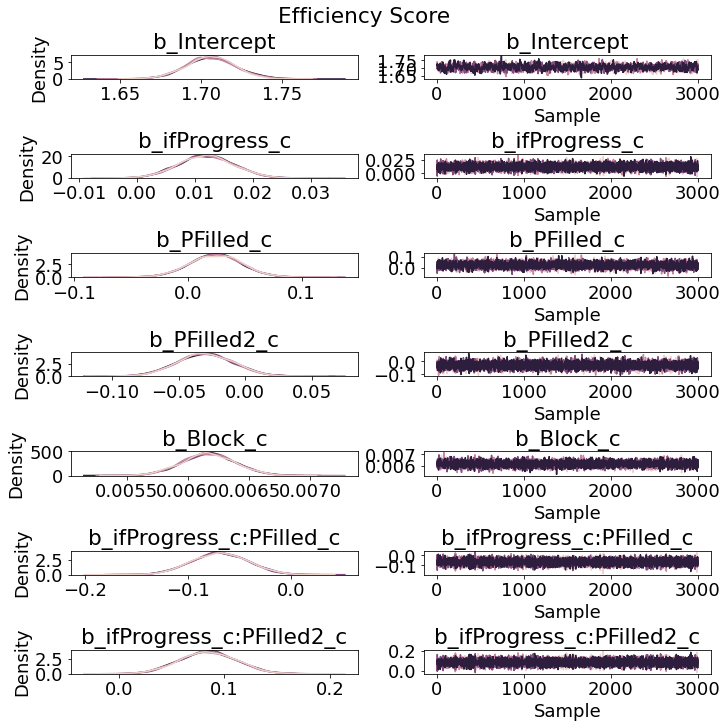

In [44]:
fig, axes = plot_trace(es_mod_post)
fig.suptitle("Efficiency Score")

In [45]:
bmlm_summary(es_mod_post).round(2)

/var/folders/2z/_glny5015ksc1wjgxn06k96m0000gn/T/ipykernel_42720/401475712.py:20: RuntimeWarning: divide by zero encountered in double_scalars
  return 1/bf


,mean,2.5%,97.5%,P,BF
b_Intercept,1.71,1.68,1.74,0.00,inf
b_ifProgress_c,0.01,0.00,0.02,0.01,145.17
b_PFilled_c,0.02,-0.02,0.07,0.14,259.07
b_PFilled2_c,-0.03,-0.07,0.01,0.08,335.20
b_Block_c,0.01,0.01,0.01,0.00,50.00
b_ifProgress_c:PFilled_c,-0.07,-0.12,-0.02,0.00,4255.32
b_ifProgress_c:PFilled2_c,0.08,0.03,0.14,0.00,25000.00


# Fixation proximity effects

Fixations towards the progress bar were analyzed in a similar fashion to performance data, using generalized linear multilevel modeling techniques in a Bayesian and frequentist framework. Again, both linear and quadratic terms are included to test for both linear and non-linear trends in looking behaviour. 

The specific model formulation is as follows: 

$$ y_{ij} = \gamma_0 + U_{0j} + \gamma_1\text{Condition}_{ij} + (\gamma_2+U_{2j})\text{P(Filled)}_{ij} + (\gamma_3+U_{3j})\text{P(Filled)}^2_{ij} +  \gamma_4\text{Block}_{ij}  + \gamma_5(\text{Condition} \times \text{P(Filled)}_{ij}) + \gamma_6(\text{Condition} \times \text{P(Filled)}^2_{ij}) + \epsilon$$

$$ U \sim MVN(0, \Sigma) $$

$$ \Sigma  = 
\begin{bmatrix}
\tau_0 & \rho_{02} & \rho_{03} \\ 
\rho_{02} & \tau_2 & \rho_{23} \\
\rho_{03} & \rho_{23} & \tau_3
\end{bmatrix} 
$$

$$ \epsilon \sim N(0, \sigma) $$

where $y_{ij}$ is the outcome variable, here fixation towards the progress bar (1=looked at progress bar, 0=did not look at progress bar) for each participant $j$ on trial $i$. Specifically, the log-odds are predicted, $y_{ij} = \log{\frac{P(Look=1)}{1-P(Look=1)}}$. $\gamma$ refers to fixed effects and $\tau$ to random variance. Unless otherwise stated, all random variances are fixed to 0. $\rho$ refers to random effects correlations and $\sigma$ to residual noise. Finally, text strings refer to observed predictor variables, which have the same definition as in the performance models (see [*Analyze performance data*](#Analyze-performance-data)).


## Visualize

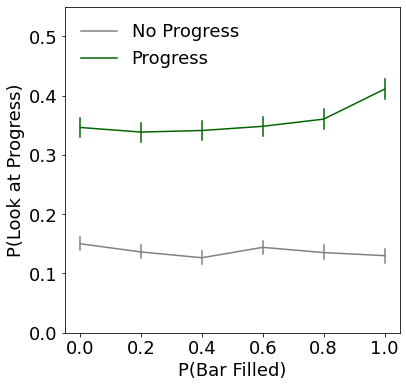

In [46]:
fig, ax = plt.subplots(1, figsize=(6,6))

nbin = 6
behav["proxbin"] = pd.qcut(behav.PFilled, nbin, labels=False)
proxlabs = np.linspace(0,1,num=nbin).round(2)

sns.lineplot(data=behav, x="proxbin", y="ifLookProg", hue="ProgressLab", ax=ax, 
            err_style="bars", palette=("grey","darkgreen"))
ax.set(xlabel="P(Bar Filled)", ylabel="P(Look at Progress)", ylim=[0,.55],
      xticks=range(nbin), xticklabels=proxlabs)
ax.legend(loc="upper left", title="", frameon=False)

## Model

In [47]:
behav["ifProgress_c"] = behav.ifProgress.astype(float) - 0.5
behav["PFilled2"]     = behav.PFilled**2
behav["PFilled_c"]    = behav.PFilled-.5
behav["PFilled2_c"]   = behav.PFilled2-np.median(behav.PFilled.unique())
behav["Accuracy_c"]   = behav.Accuracy - .5
behav["Block_c"]      = behav.Block.astype(float) - behav.Block.astype(float).median()
behav["logrt"]        = np.log(behav.RT)

### Frequentist

Randome effects in line with performance analyses. Including random variance of `PFilled2_c` per subject does not change interpretation of effects.

In [48]:
%%R -i behav -o look_mod_f

# look_mod_f = glmer(ifLookProg ~ ifProgress_c * (PFilled_c + PFilled2_c) +
#                  Block_c + (PFilled_c|PID), family="binomial",
#                 data=behav, nAGQ=0)
# saveRDS(look_mod_f, "out/look_glmer_f.rds")


look_mod_f = readRDS("out/look_glmer_f.rds")
summary(look_mod_f)

/opt/anaconda3/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "progStartLoc". Fall back to string conversion. The error is: <class 'float'>
  warnings.warn('Error while trying to convert '
/opt/anaconda3/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "progEndLoc". Fall back to string conversion. The error is: <class 'float'>
  warnings.warn('Error while trying to convert '
/opt/anaconda3/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "progPosition". Fall back to string conversion. The error is: <class 'float'>
  warnings.warn('Error while trying to convert '


Generalized linear mixed model fit by maximum likelihood (Adaptive
  Gauss-Hermite Quadrature, nAGQ = 0) [glmerMod]
 Family: binomial  ( logit )
Formula: ifLookProg ~ ifProgress_c * (PFilled_c + PFilled2_c) + Block_c +  
    (PFilled_c | PID)
   Data: behav

     AIC      BIC   logLik deviance df.resid 
 25706.8  25793.2 -12843.4  25686.8    41664 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-15.8297  -0.3188  -0.1291  -0.0184  29.4158 

Random effects:
 Groups Name        Variance Std.Dev. Corr 
 PID    (Intercept) 6.038    2.457         
        PFilled_c   1.032    1.016    -0.02
Number of obs: 41674, groups:  PID, 81

Fixed effects:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)             -1.994009   0.277133  -7.195 6.24e-13 ***
ifProgress_c             2.408114   0.079960  30.117  < 2e-16 ***
PFilled_c               -0.838909   0.255104  -3.289  0.00101 ** 
PFilled2_c               1.101571   0.221102   4.982 6.29e-07 ***
Blo

### Bayesian

In [49]:
%%R -i behav -o look_mod_post

# options(mc.cores=4) # parallel processing

# look_mod_b = brm(ifLookProg ~ ifProgress_c * (PFilled_c + PFilled2_c) +
#                  Block_c + (PFilled_c + PFilled2_c||PID), family=bernoulli,
#                 data=behav,
#                 iter=5000,
#                 chains=4,
#                 warmup=2000, 
#                 thin=1)

# saveRDS(look_mod_b, "out/look_glmer_b.rds")
# print(summary(look_mod_b))

look_mod_b = readRDS("out/look_glmer_b.rds")
print(summary(look_mod_b))
look_mod_post = as.data.frame(look_mod_b)


 Family: bernoulli 
  Links: mu = logit 
Formula: ifLookProg ~ ifProgress_c * (PFilled_c + PFilled2_c) + Block_c + (PFilled_c + PFilled2_c || PID) 
   Data: behav (Number of observations: 41674) 
  Draws: 4 chains, each with iter = 5000; warmup = 2000; thin = 1;
         total post-warmup draws = 12000

Multilevel Hyperparameters:
~PID (Number of levels: 81) 
               Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)      2.49      0.21     2.13     2.95 1.00     1518     3078
sd(PFilled_c)      0.97      0.15     0.67     1.28 1.00     4858     7590
sd(PFilled2_c)     0.64      0.22     0.14     1.03 1.00     1728     1604

Regression Coefficients:
                        Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS
Intercept                  -2.01      0.29    -2.56    -1.46 1.01      515
ifProgress_c                2.42      0.08     2.26     2.58 1.00     9897
PFilled_c                  -0.84      0.25    -1.33    -0.34 1.00    10465
PFilled2_c  

Text(0.5, 0.98, 'P(Look at Progress)')

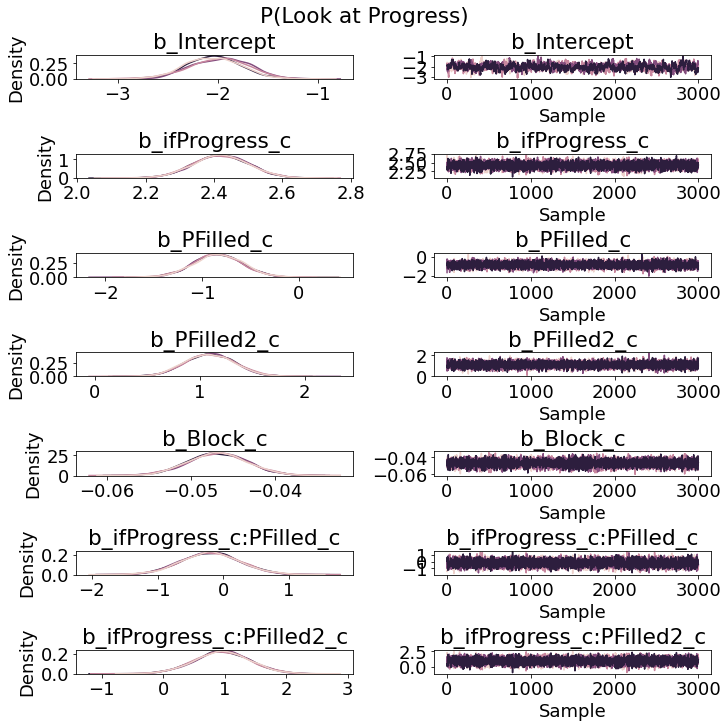

In [50]:
fig, axes = plot_trace(look_mod_post)
fig.suptitle("P(Look at Progress)")

In [51]:
bmlm_summary(look_mod_post).round(2)

/var/folders/2z/_glny5015ksc1wjgxn06k96m0000gn/T/ipykernel_42720/401475712.py:20: RuntimeWarning: divide by zero encountered in double_scalars
  return 1/bf


,mean,2.5%,97.5%,P,BF
b_Intercept,-2.01,-2.56,-1.46,0.00,inf
b_ifProgress_c,2.42,2.26,2.58,0.00,inf
b_PFilled_c,-0.84,-1.33,-0.34,0.00,600000.00
b_PFilled2_c,1.10,0.64,1.56,0.00,inf
b_Block_c,-0.05,-0.05,-0.04,0.00,inf
b_ifProgress_c:PFilled_c,-0.19,-1.06,0.70,0.33,3571.43
b_ifProgress_c:PFilled2_c,0.96,0.06,1.84,0.02,26086.96


## Tentative pupillometry
The task is not really calibrated for pupil analysis. Steps were taken to try to mitigate this in [`eye/process.py`](eye/process.py), but this remains heavily exploratory.

Here, I focus only on pupil diameter during task performance, not during progress sampling, which is (more) confounded by gaze position.

### Phasic Signal

#### Baseline correct TERPs

In [67]:
behav["TERP_mu_bc"]  = behav.phasic_pupil_terp_mean - behav.phasic_pupil_base
behav["TERP_max_bc"] = behav.phasic_pupil_terp_max  - behav.phasic_pupil_base

In [68]:
## remove crazy outliets
behav.TERP_max_bc[behav.TERP_max_bc>10] = np.nan
behav.phasic_pupil_base[behav.phasic_pupil_base.abs()>10] = np.nan

#### Restrict to correct trials

In [69]:
cor = behav[behav.Accuracy==1]

#### Visualize

Lineplot

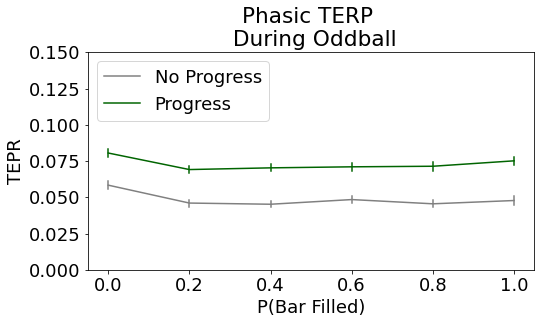

In [70]:
fig, ax = plt.subplots(1, figsize=(8,4))

nbin = 6
cor["proxbin"] = pd.qcut(cor.PFilled, nbin, labels=False)
proxlabs = np.linspace(0,1,num=nbin).round(2)

sns.lineplot(data=cor, x="proxbin", y="TERP_max_bc", hue="ProgressLab", ax=ax, 
            errorbar="se", err_style="bars",
             palette=("grey","darkgreen"))
ax.set(xlabel="P(Bar Filled)", 
       ylabel="TEPR", 
       title="Phasic TERP \n During Oddball",
       ylim=[0,0.15],
      xticks=range(nbin), xticklabels=proxlabs)
ax.legend(loc="upper left", title="")

Barplot

[Text(0.5, 0, 'Progress Condition'),
 Text(0, 0.5, 'TEPR'),
 Text(0.5, 1.0, 'Phasic TERP \n During Oddball'),
 (0.0, 0.15)]

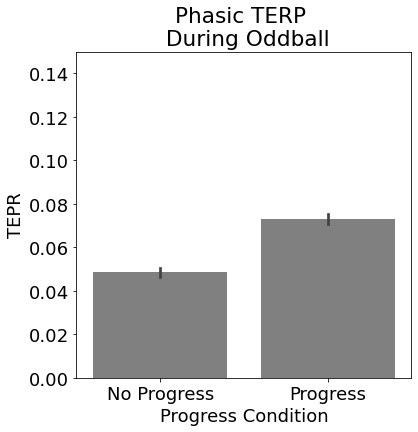

In [71]:
fig, ax = plt.subplots(1, figsize=(6,6))

sns.barplot(data=cor, x="ProgressLab", y="TERP_max_bc", ax=ax, 
            errorbar=('ci', 95), color="grey")
ax.set(xlabel="Progress Condition", 
       ylabel="TEPR", 
       title="Phasic TERP \n During Oddball",
       ylim=[0,0.15])


#### Model

##### Frequentist

In [72]:
%%R -i cor -o phasic_mod_f

# phasic_mod_f = lmer(TERP_max_bc ~ ifProgress_c * (PFilled_c + PFilled2_c) +
#                  Block_c + (PFilled_c|PID),
#                 data=cor)
# saveRDS(phasic_mod_f, "out/phasic_mod_f.rds")

phasic_mod_f = readRDS("out/phasic_mod_f.rds")
summary(phasic_mod_f)

/opt/anaconda3/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "progStartLoc". Fall back to string conversion. The error is: <class 'float'>
  warnings.warn('Error while trying to convert '
/opt/anaconda3/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "progEndLoc". Fall back to string conversion. The error is: <class 'float'>
  warnings.warn('Error while trying to convert '
/opt/anaconda3/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "progPosition". Fall back to string conversion. The error is: <class 'float'>
  warnings.warn('Error while trying to convert '


Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: TERP_max_bc ~ ifProgress_c * (PFilled_c + PFilled2_c) + Block_c +  
    (PFilled_c | PID)
   Data: cor

REML criterion at convergence: -13125.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-12.954  -0.314  -0.068   0.224 141.061 

Random effects:
 Groups   Name        Variance  Std.Dev.  Corr
 PID      (Intercept) 1.804e-03 4.247e-02     
          PFilled_c   3.181e-10 1.783e-05 0.98
 Residual             4.142e-02 2.035e-01     
Number of obs: 38811, groups:  PID, 81

Fixed effects:
                          Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)              6.794e-02  5.319e-03  1.176e+02  12.774  < 2e-16 ***
ifProgress_c             2.050e-02  4.904e-03  3.872e+04   4.180 2.93e-05 ***
PFilled_c               -4.970e-02  1.390e-02  3.872e+04  -3.575 0.000351 ***
PFilled2_c               4.286e-02  1.390e-02  3.872e+04   3.084 0.002043 ** 
Block_c  

##### Bayesian

In [73]:
%%R -i cor -o phasic_mod_post

# options(mc.cores=4) # parallel processing

# phasic_mod_b = brm(TERP_max_bc ~ ifProgress_c * (PFilled_c + PFilled2_c) +
#                  Block_c + (PFilled_c|PID),
#                  data=cor,
#                  iter=5000,
#                  chains=4,
#                  warmup=2000, 
#                  thin=1)

# saveRDS(phasic_mod_b, "out/phasic_mod_b.rds")
# print(summary(phasic_mod_b))

phasic_mod_b = readRDS("out/phasic_mod_b.rds")
print(summary(phasic_mod_b))
phasic_mod_post = as.data.frame(phasic_mod_b)


 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: TERP_max_bc ~ ifProgress_c * (PFilled_c + PFilled2_c) + Block_c + (PFilled_c | PID) 
   Data: cor (Number of observations: 38810) 
  Draws: 4 chains, each with iter = 5000; warmup = 2000; thin = 1;
         total post-warmup draws = 12000

Multilevel Hyperparameters:
~PID (Number of levels: 81) 
                         Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS
sd(Intercept)                0.04      0.00     0.04     0.05 1.00     1650
sd(PFilled_c)                0.02      0.00     0.01     0.03 1.00     3820
cor(Intercept,PFilled_c)     0.05      0.19    -0.30     0.41 1.00    12456
                         Tail_ESS
sd(Intercept)                2865
sd(PFilled_c)                3371
cor(Intercept,PFilled_c)     8501

Regression Coefficients:
                        Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS
Intercept                   0.07      0.01     0.06     0.08 1.00      714
ifProgress_c     

Text(0.5, 0.98, 'Phasic Pupil Size')

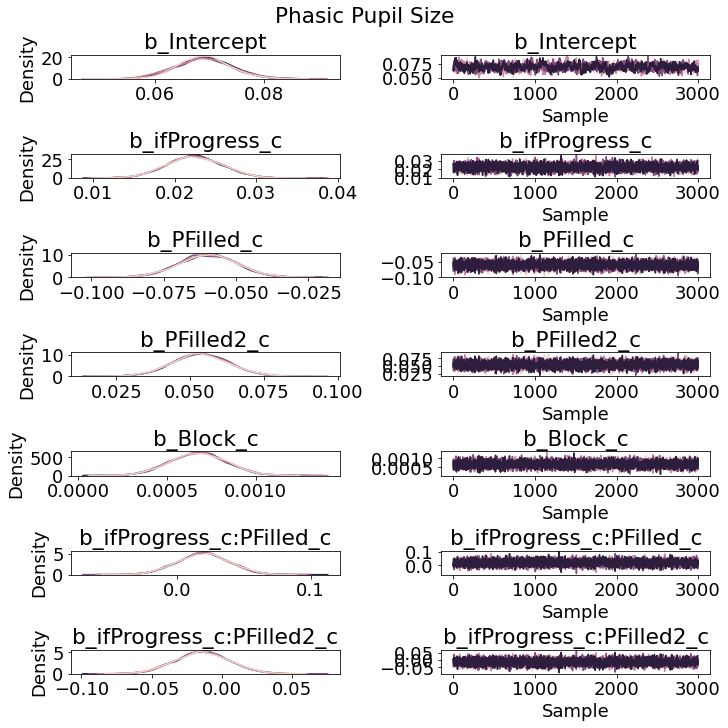

In [74]:
fig, axes = plot_trace(phasic_mod_post)
fig.suptitle("Phasic Pupil Size")

In [75]:
bmlm_summary(phasic_mod_post).round(2)

/var/folders/2z/_glny5015ksc1wjgxn06k96m0000gn/T/ipykernel_42720/401475712.py:20: RuntimeWarning: divide by zero encountered in double_scalars
  return 1/bf


,mean,2.5%,97.5%,P,BF
b_Intercept,0.07,0.06,0.08,0.00,inf
b_ifProgress_c,0.02,0.02,0.03,0.00,inf
b_PFilled_c,-0.06,-0.08,-0.04,0.00,inf
b_PFilled2_c,0.05,0.03,0.07,0.00,inf
b_Block_c,0.00,0.00,0.00,0.00,50.00
b_ifProgress_c:PFilled_c,0.02,-0.02,0.06,0.16,209.13
b_ifProgress_c:PFilled2_c,-0.01,-0.05,0.02,0.24,159.74


### Tonic Signal

Tonic signals can be defined in two ways. 

1. As the phasic signal at baseline, before stimulus onset. 
2. As the low-frequency signal that drifts over time. 

We visualize and model both below. 

#### Tonic: Pre-Trial Phasic

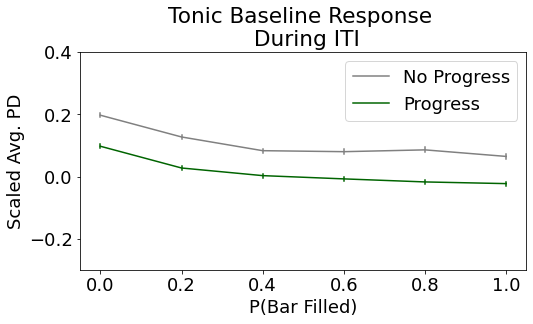

In [76]:
fig, ax = plt.subplots(1, figsize=(8,4))

nbin = 6
cor["proxbin"] = pd.qcut(cor.PFilled, nbin, labels=False)
proxlabs = np.linspace(0,1,num=nbin).round(2)

sns.lineplot(data=cor, x="proxbin", y="phasic_pupil_base", hue="ProgressLab", ax=ax, 
            errorbar="se", err_style="bars",
             palette=("grey","darkgreen"))
ax.set(xlabel="P(Bar Filled)", 
       ylabel="Scaled Avg. PD", 
       title="Tonic Baseline Response \n During ITI",
       ylim=[-0.3,0.4],
      xticks=range(nbin), xticklabels=proxlabs)
ax.legend(loc="upper right", title="")

##### Model: Frequentist

In [77]:
%%R -i cor -o tonic_pt_mod_f

# tonic_pt_mod_f = lmer(phasic_pupil_base ~ ifProgress_c * (PFilled_c + PFilled2_c) +
#                  Block_c + (PFilled_c||PID),
#                 data=cor)
# saveRDS(tonic_pt_mod_f, "out/tonic_pt_mod_f.rds")

tonic_pt_mod_f = readRDS("out/tonic_pt_mod_f.rds")
summary(tonic_pt_mod_f)

/opt/anaconda3/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "progStartLoc". Fall back to string conversion. The error is: <class 'float'>
  warnings.warn('Error while trying to convert '
/opt/anaconda3/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "progEndLoc". Fall back to string conversion. The error is: <class 'float'>
  warnings.warn('Error while trying to convert '
/opt/anaconda3/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "progPosition". Fall back to string conversion. The error is: <class 'float'>
  warnings.warn('Error while trying to convert '


Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: phasic_pupil_base ~ ifProgress_c * (PFilled_c + PFilled2_c) +  
    Block_c + (PFilled_c || PID)
   Data: cor

REML criterion at convergence: 38028.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-72.130  -0.369   0.010   0.404  20.969 

Random effects:
 Groups   Name        Variance Std.Dev.
 PID      (Intercept) 0.02058  0.1435  
 PID.1    PFilled_c   0.01885  0.1373  
 Residual             0.15388  0.3923  
Number of obs: 38811, groups:  PID, 81

Fixed effects:
                          Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)              1.051e-01  1.663e-02  9.180e+01   6.321 9.24e-09 ***
ifProgress_c            -8.438e-02  9.452e-03  3.864e+04  -8.926  < 2e-16 ***
PFilled_c               -3.967e-01  3.084e-02  9.102e+02 -12.864  < 2e-16 ***
PFilled2_c               2.750e-01  2.679e-02  3.864e+04  10.268  < 2e-16 ***
Block_c                 -7.788e

##### Model: Bayesian

In [78]:
# %%R -i cor -o tonic_pt_mod_post

# options(mc.cores=4) # parallel processing

# tonic_pt_mod_b = brm(phasic_pupil_base ~ ifProgress_c * (PFilled_c + PFilled2_c) +
#                      Block_c + (PFilled_c|PID),
#                      data=cor,
#                      iter=5000,
#                      chains=4,
#                      warmup=2000, 
#                      thin=1)

# saveRDS(tonic_pt_mod_b, "out/tonic_pt_mod_b.rds")
# print(summary(tonic_pt_mod_b))

# tonic_pt_mod_b = readRDS("out/tonic_pt_mod_b.rds")
# print(summary(tonic_pt_mod_b))
# tonic_pt_mod_post = as.data.frame(tonic_pt_mod_post)


In [79]:
# fig, axes = plot_trace(tonic_pt_mod_b)
# fig.suptitle("Tonic Pupil Size (Pre-Trial)")

#### Tonic: Low-Frequency Drift

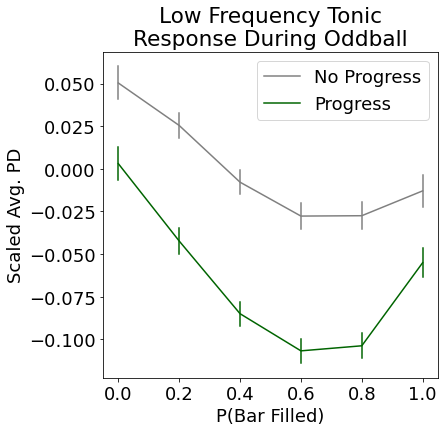

In [80]:
fig, ax = plt.subplots(1, figsize=(6,6))

nbin = 6
cor["proxbin"] = pd.qcut(cor.PFilled, nbin, labels=False)
proxlabs = np.linspace(0,1,num=nbin).round(2)

sns.lineplot(data=cor, x="proxbin", y="tonic_pupil_terp_mean", hue="ProgressLab", ax=ax, 
            errorbar="se", err_style="bars",
             palette=("grey","darkgreen"))
ax.set(xlabel="P(Bar Filled)", 
       ylabel="Scaled Avg. PD", 
       title="Low Frequency Tonic\nResponse During Oddball",
      xticks=range(nbin), xticklabels=proxlabs)
ax.legend(loc="upper right", title="")

##### Model: Frequentist

In [81]:
%%R -i cor -o tonic_lf_mod_f

# tonic_lf_mod_f = lmer(tonic_pupil_terp_mean ~ ifProgress_c * (PFilled_c + PFilled2_c) +
#                  Block_c + (PFilled_c|PID),
#                 data=cor)
# saveRDS(tonic_lf_mod_f, "out/tonic_lf_mod_f.rds")

tonic_lf_mod_f = readRDS("out/tonic_lf_mod_f.rds")
summary(tonic_lf_mod_f)

/opt/anaconda3/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "progStartLoc". Fall back to string conversion. The error is: <class 'float'>
  warnings.warn('Error while trying to convert '
/opt/anaconda3/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "progEndLoc". Fall back to string conversion. The error is: <class 'float'>
  warnings.warn('Error while trying to convert '
/opt/anaconda3/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "progPosition". Fall back to string conversion. The error is: <class 'float'>
  warnings.warn('Error while trying to convert '


Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: tonic_pupil_terp_mean ~ ifProgress_c * (PFilled_c + PFilled2_c) +  
    Block_c + (PFilled_c | PID)
   Data: cor

REML criterion at convergence: 41226.9

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-12.9450  -0.3777  -0.0038   0.3897  11.3097 

Random effects:
 Groups   Name        Variance Std.Dev. Corr
 PID      (Intercept) 0.036374 0.19072      
          PFilled_c   0.009673 0.09835  0.18
 Residual             0.167138 0.40882      
Number of obs: 38811, groups:  PID, 81

Fixed effects:
                          Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)              2.184e-02  2.176e-02  8.720e+01   1.004 0.318320    
ifProgress_c            -2.306e-02  9.851e-03  3.864e+04  -2.341 0.019257 *  
PFilled_c               -3.831e-01  2.999e-02  2.133e+03 -12.776  < 2e-16 ***
PFilled2_c               3.086e-01  2.792e-02  3.864e+04  11.053  < 2e-16 **

##### Break up by condition

No Progress condition: 

In [88]:
%%R -i cor -o mod_np

mod_np = lmer(tonic_pupil_terp_mean ~ PFilled_c + PFilled2_c +Block_c + (PFilled_c|PID),
                data=cor[cor$ifProgress==0, ])
summary(mod_np)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: 
tonic_pupil_terp_mean ~ PFilled_c + PFilled2_c + Block_c + (PFilled_c |  
    PID)
   Data: cor[cor$ifProgress == 0, ]

REML criterion at convergence: 21277.5

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-11.9627  -0.3900  -0.0126   0.3928  10.5820 

Random effects:
 Groups   Name        Variance Std.Dev. Corr
 PID      (Intercept) 0.03702  0.1924       
          PFilled_c   0.04352  0.2086   0.17
 Residual             0.17092  0.4134       
Number of obs: 19403, groups:  PID, 81

Fixed effects:
              Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)  3.302e-02  2.251e-02  9.459e+01   1.467    0.146    
PFilled_c   -2.783e-01  4.618e-02  8.575e+02  -6.026 2.49e-09 ***
PFilled2_c   2.000e-01  3.993e-02  1.924e+04   5.008 5.54e-07 ***
Block_c     -1.471e-02  6.609e-04  1.928e+04 -22.255  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.0

Progress condition:

In [89]:
%%R -i cor -o mod_pr

mod_pr = lmer(tonic_pupil_terp_mean ~ PFilled_c + PFilled2_c +Block_c + (PFilled_c|PID),
                data=cor[cor$ifProgress==1, ])
summary(mod_pr)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: 
tonic_pupil_terp_mean ~ PFilled_c + PFilled2_c + Block_c + (PFilled_c |  
    PID)
   Data: cor[cor$ifProgress == 1, ]

REML criterion at convergence: 17725.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-9.1043 -0.3803 -0.0079  0.3936 10.6495 

Random effects:
 Groups   Name        Variance Std.Dev. Corr
 PID      (Intercept) 0.05303  0.2303       
          PFilled_c   0.03301  0.1817   0.07
 Residual             0.14201  0.3768       
Number of obs: 19408, groups:  PID, 81

Fixed effects:
              Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)  9.752e-03  2.638e-02  8.843e+01    0.37    0.713    
PFilled_c   -4.881e-01  4.163e-02  9.568e+02  -11.72   <2e-16 ***
PFilled2_c   4.171e-01  3.639e-02  1.924e+04   11.46   <2e-16 ***
Block_c     -1.273e-02  6.071e-04  1.927e+04  -20.96   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 

##### Model: Bayesian

In [82]:
%%R -i cor -o tonic_lf_mod_post

# options(mc.cores=4) # parallel processing

# tonic_lf_mod_b = brm(tonic_pupil_terp_mean ~ ifProgress_c * (PFilled_c + PFilled2_c) +
#                      Block_c + (PFilled_c|PID),
#                      data=cor,
#                      iter=5000,
#                      chains=4,
#                      warmup=2000, 
#                      thin=1)

# saveRDS(tonic_lf_mod_b, "out/tonic_lf_mod_b.rds")
# print(summary(tonic_lf_mod_b))

tonic_lf_mod_b = readRDS("out/tonic_lf_mod_b.rds")
print(summary(tonic_lf_mod_b))
tonic_lf_mod_post = as.data.frame(tonic_lf_mod_b)


 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: tonic_pupil_terp_mean ~ ifProgress_c * (PFilled_c + PFilled2_c) + Block_c + (PFilled_c | PID) 
   Data: cor (Number of observations: 38811) 
  Draws: 4 chains, each with iter = 5000; warmup = 2000; thin = 1;
         total post-warmup draws = 12000

Multilevel Hyperparameters:
~PID (Number of levels: 81) 
                         Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS
sd(Intercept)                0.19      0.02     0.17     0.23 1.01      624
sd(PFilled_c)                0.10      0.01     0.08     0.12 1.00     3965
cor(Intercept,PFilled_c)     0.17      0.13    -0.09     0.42 1.00     3403
                         Tail_ESS
sd(Intercept)                1070
sd(PFilled_c)                6842
cor(Intercept,PFilled_c)     5034

Regression Coefficients:
                        Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS
Intercept                   0.02      0.02    -0.02     0.07 1.01      290
ifProgr

Text(0.5, 0.98, 'Tonic Pupil Size (Low-Frequency)')

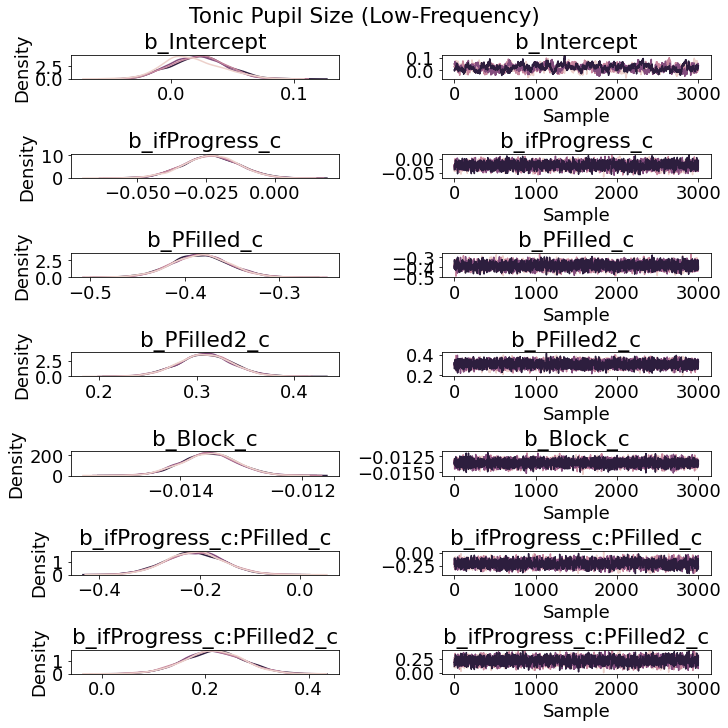

In [83]:
fig, axes = plot_trace(tonic_lf_mod_post)
fig.suptitle("Tonic Pupil Size (Low-Frequency)")

In [84]:
bmlm_summary(tonic_lf_mod_post).round(2)

/var/folders/2z/_glny5015ksc1wjgxn06k96m0000gn/T/ipykernel_42720/401475712.py:20: RuntimeWarning: divide by zero encountered in double_scalars
  return 1/bf


,mean,2.5%,97.5%,P,BF
b_Intercept,0.02,-0.02,0.07,0.18,206.68
b_ifProgress_c,-0.02,-0.04,-0.00,0.01,527.70
b_PFilled_c,-0.38,-0.44,-0.32,0.00,inf
b_PFilled2_c,0.31,0.25,0.36,0.00,inf
b_Block_c,-0.01,-0.01,-0.01,0.00,inf
b_ifProgress_c:PFilled_c,-0.21,-0.32,-0.10,0.00,600000.00
b_ifProgress_c:PFilled2_c,0.22,0.10,0.33,0.00,300000.00
